## Tentativa de Previsão de Oleo com base em dados Multivariados

#### Carregando libs necessárias

In [35]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
from keras.models import Sequential
# from keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import GRU, Dense,Dropout,LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler,LabelEncoder
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_absolute_error , mean_squared_error
import optuna
# pip install optuna
!pip install optuna-integration


from time import time_ns
import random
import keras

SEED = 10

random.seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)


[notice] A new release of pip is available: 23.0.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Função para a preparação dos dados para o modelo de previsão

In [36]:
# The function is defined with default parameters so that if you call it with just your data, it will construct a DataFrame with t-1 
# as X and t as y

def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

#### Carregando a base de dados

In [37]:
###########################################################
file_name = r"C:\Users\vinicius\Documents\Repositorios\TimeSeriesPredictionFinalProject\src\data\Base_Volve_Pocos.xlsx" # File name
###########################################################

#MELHOR PARA TREINAR E FICAR BOM: 'NO15-9-F-1-C'>'NO15-9-F-15-D' -> Esse cara vai muito para zero
# BOM MAS COM PERFIL SHIFITADO 'NO15-9-F-11-H'~=~'NO15-9-F-12-H'#
sheet_name ='NO15-9-F-1-C' #'NO15-9-F-12-H'# 'NO15-9-F-14-H'#'NO15-9-F-15-D'#'NO15-9-F-11-H'#'NO15-9-F-12-H'#'NO15-9-F-11-H'# 4th sheet
header = 0 # The header is the 2nd row
df_full = pd.read_excel(file_name, sheet_name = sheet_name, header = header)
df_full.head()

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


#### Verificação se todos os dados da base são referentes a um poço produtor

In [38]:
df_filter=df_full[df_full['WELL_TYPE'] != 'WI']
df_filter.isna().sum()

DATEPRD                       0
WELL_BORE_CODE                0
NPD_WELL_BORE_CODE            0
NPD_WELL_BORE_NAME            0
NPD_FIELD_CODE                0
NPD_FIELD_NAME                0
NPD_FACILITY_CODE             0
NPD_FACILITY_NAME             0
ON_STREAM_HRS                 0
AVG_DOWNHOLE_PRESSURE         3
AVG_DOWNHOLE_TEMPERATURE      3
AVG_DP_TUBING                 3
AVG_ANNULUS_PRESS           728
AVG_CHOKE_SIZE_P              0
AVG_CHOKE_UOM                 0
AVG_WHP_P                     0
AVG_WHT_P                     0
DP_CHOKE_SIZE                 0
BORE_OIL_VOL                  0
BORE_GAS_VOL                  0
BORE_WAT_VOL                  0
BORE_WI_VOL                 744
FLOW_KIND                     0
WELL_TYPE                     0
dtype: int64

#### Remoção de colunas desnecessárias

In [39]:
df_filter=df_filter.drop(columns=['WELL_BORE_CODE','NPD_WELL_BORE_CODE', 'NPD_WELL_BORE_NAME',
                                  'NPD_FIELD_CODE','NPD_FIELD_NAME',
                                  'NPD_FACILITY_CODE','NPD_FACILITY_NAME',
                                  'AVG_CHOKE_UOM','FLOW_KIND',
                                  'WELL_TYPE','BORE_WI_VOL'])

#### Plot de todos os dados da base de dados

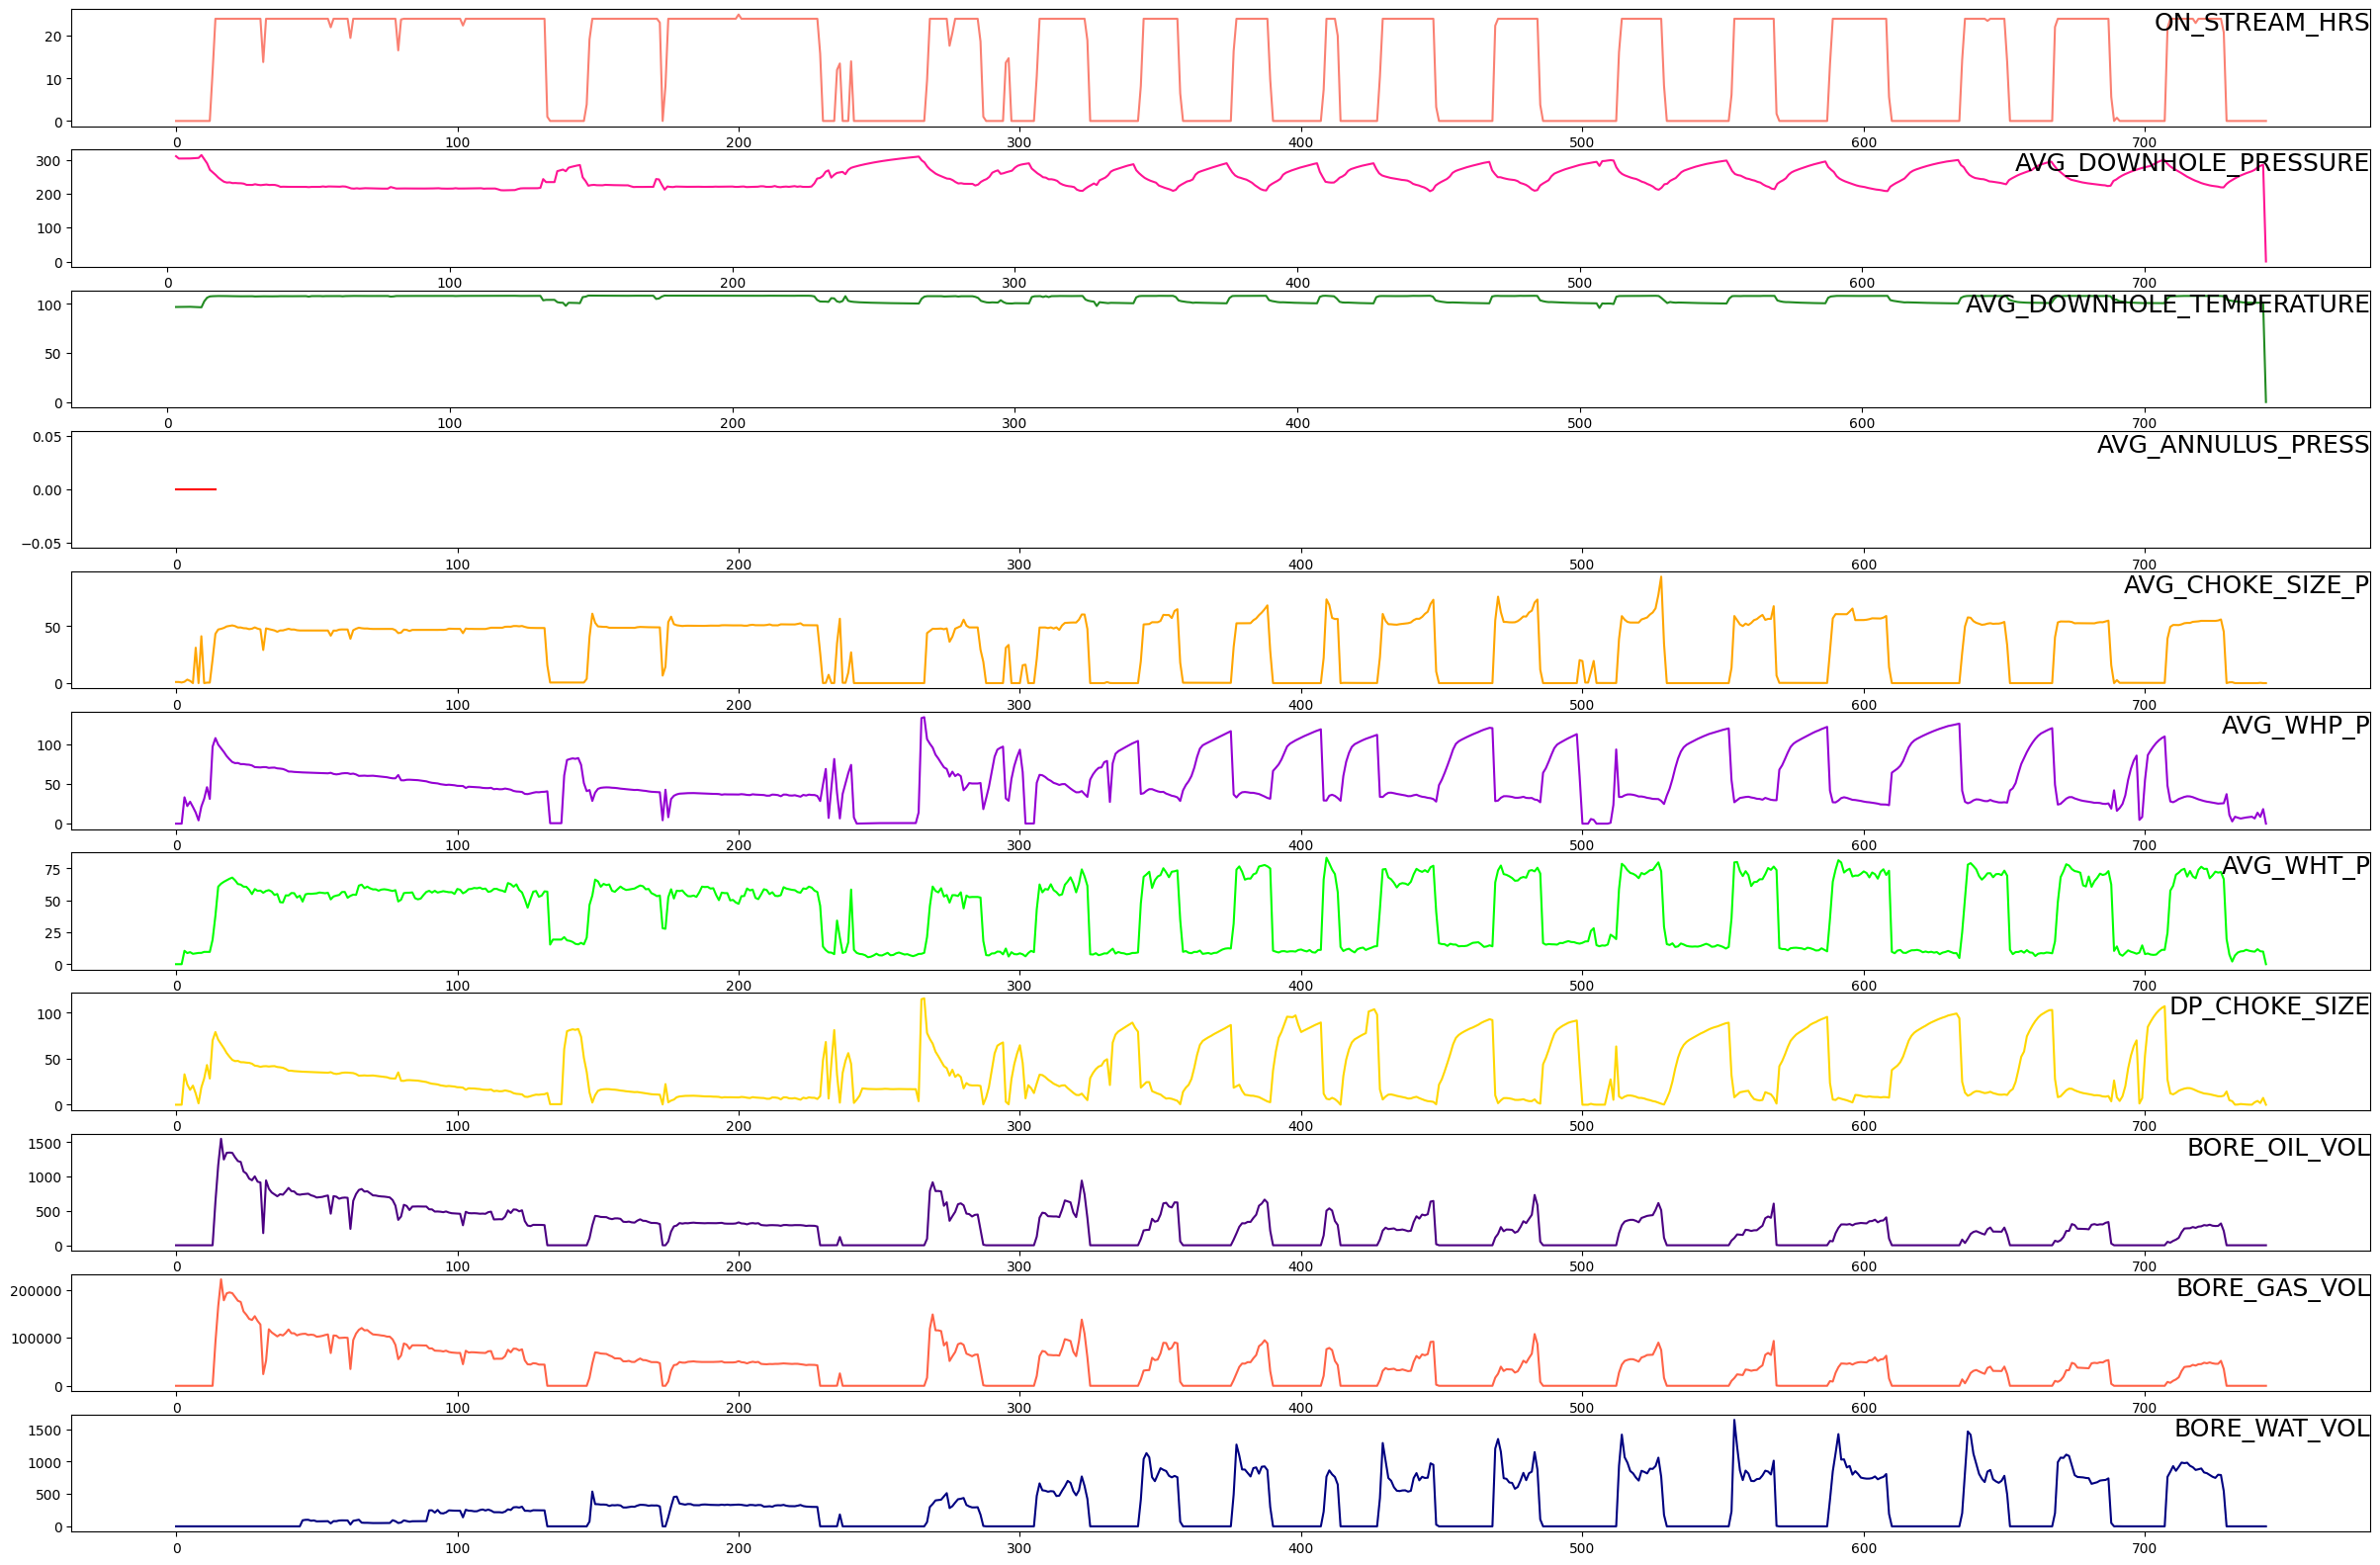

In [40]:
values = df_filter.values

# specify columns to plot
groups = [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12]
i = 1
colors=['blue','salmon','deeppink',"forestgreen",'red','orange','darkviolet','lime','gold','indigo','tomato','navy']

# plot each column
plt.figure(figsize=(30,20))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group], c = colors[i])
    plt.title(df_filter.columns[group], y=0.75, loc='right', fontsize = 18)
    i += 1
plt.show()

#### Filtro para selecionar apenas as features desejadas

In [41]:
target = df_filter[['BORE_OIL_VOL','BORE_WAT_VOL','BORE_GAS_VOL','AVG_WHP_P','AVG_WHT_P']]

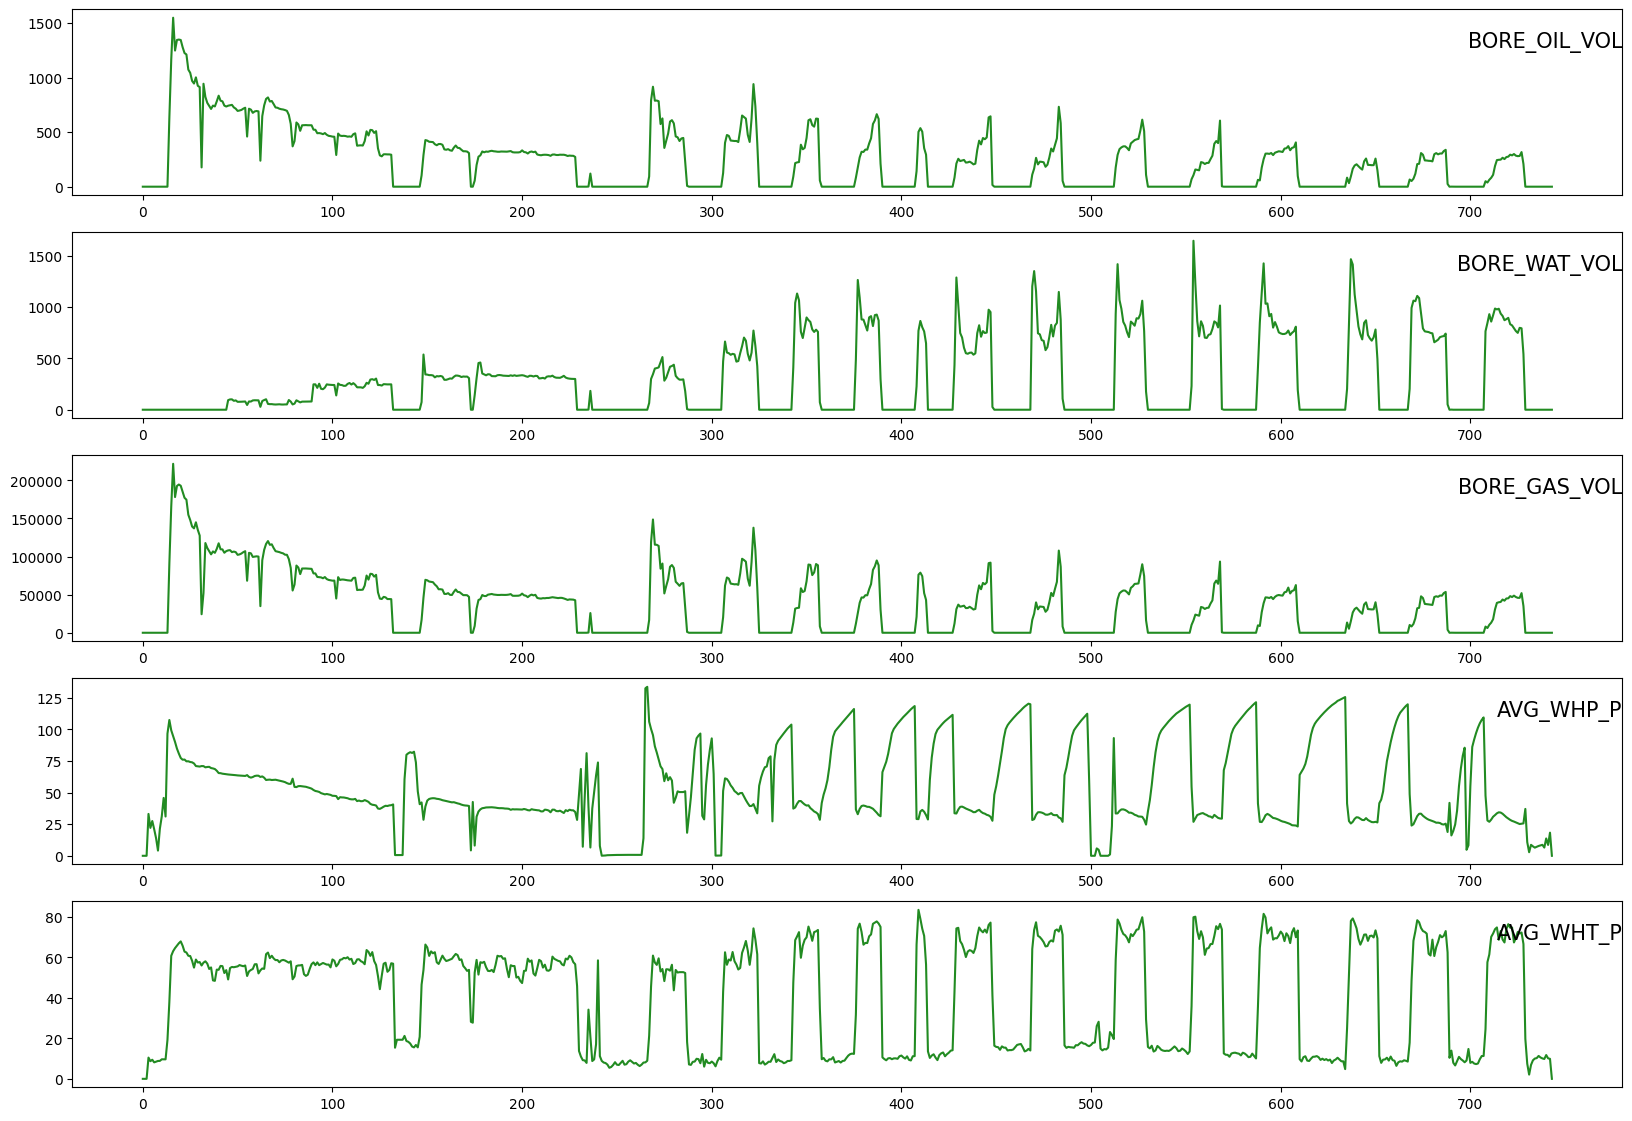

In [42]:
values = target.values

# specify columns to plot
groups = [0, 1, 2, 3, 4]
i = 1
# plot each column
plt.figure(figsize=(20,14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group], c = "forestgreen")
    plt.title(target.columns[group], y=0.75, loc='right', fontsize = 15)
    i += 1
plt.show()

#### Visualização do perfil completo da produção de Oleo

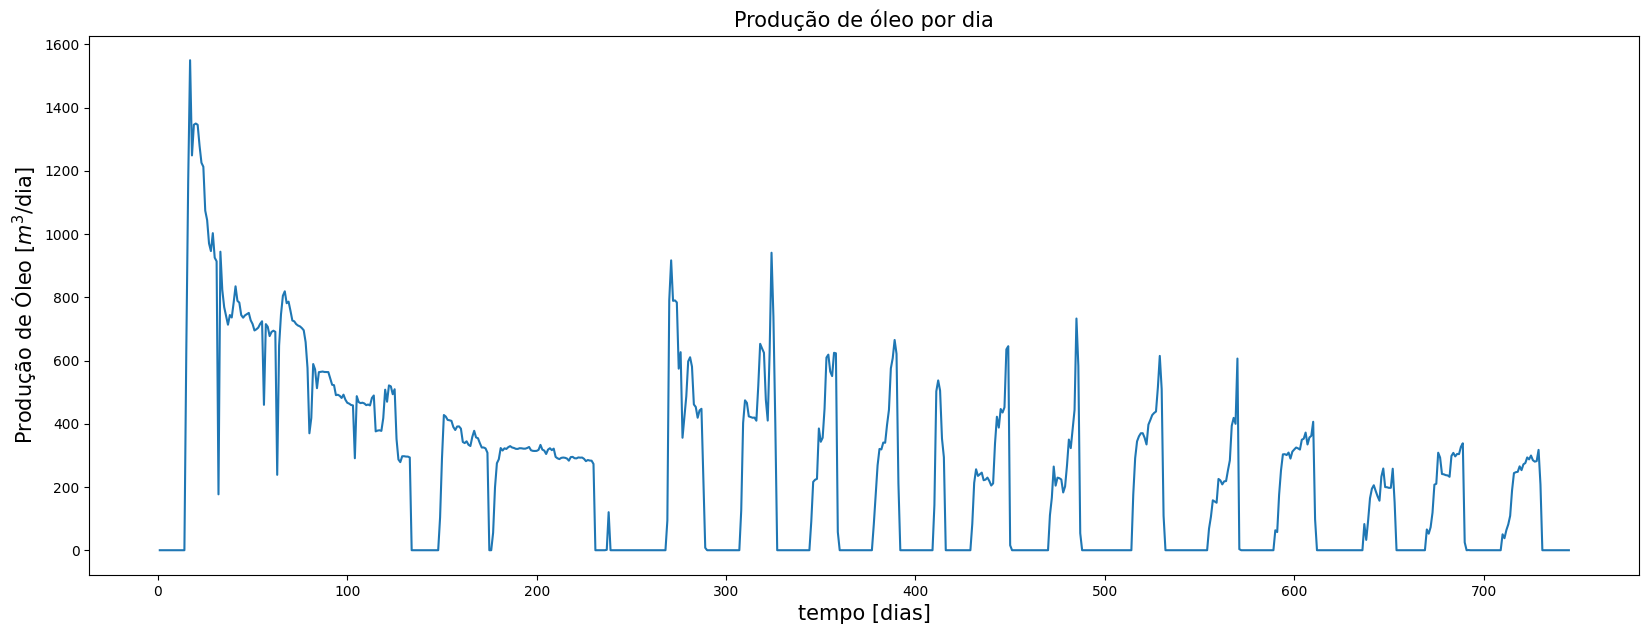

In [43]:
fig = plt.figure(figsize = (20,7))
plt.plot(target.BORE_OIL_VOL)
plt.title("Produção de óleo por dia", fontsize = 15)
plt.xlabel('tempo [dias]', fontsize = 15)
plt.ylabel(r'Produção de Óleo [$m^3$/dia]', fontsize = 15)  # LaTeX formatting for the y-label
plt.show()

#### Heatmap da correlação entre os dados

<Axes: >

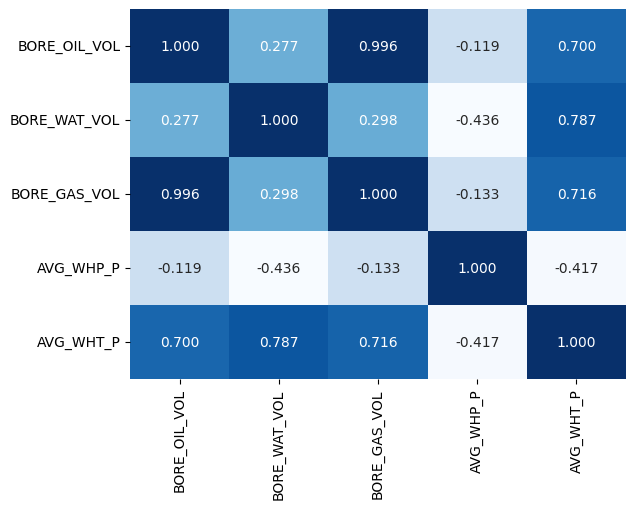

In [44]:
sns.heatmap(target.corr(),annot=True, cbar=False, cmap='Blues', fmt='.3f')

#### Preparação da base de dados para criação do modelo

In [45]:
# Scaling the entire dataset

dataset = target
values = dataset.values

values = values.astype('float32')

# Fazendo uma normalização nos dados para ficarem entre 0 e 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

## Vamos jogar o Optuna apartir desse ponto

In [46]:
# Define a callback to save information
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, trial):
        self.trial = trial
        self.best_val_loss = float('inf')
        self.best_model = None

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs['val_loss']
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_model = self.model
        self.trial.report(val_loss, step=epoch)
        if self.trial.should_prune():
            raise optuna.TrialPruned()

In [47]:
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.optimizers import Adam
import pickle

In [48]:
epochs = 300 # Choose the number of training epochs
batch_size = 1#5#10 # Choose the batch size for training

In [49]:
def objective(trial):
    # Define the Optuna search space for hyperparameters
    window_size = trial.suggest_int('window_size', 1, 100)  # Adjust the range as needed
    batch_size = 1#trial.suggest_int('window_size', 1, 30)  # Adjust the range as needed
    # n_lstm_layers = trial.suggest_int('n_lstm_layers', 1, 10)
    lstm_units = 50#trial.suggest_int('lstm_units', 32, 256)
    learning_rate = 1e-4#trial.suggest_float('learning_rate', 1e-4, 1e-2)

    ## Create the dataset
    reframed = series_to_supervised(scaled, window_size, 1)

    # droping columns we don't want to predict
    columns_to_drop = ['var2(t)', 'var3(t)', 'var4(t)', 'var5(t)']
    reframed.drop(columns_to_drop, axis=1, inplace=True)

    train_ratio = 0.8

    # Split the dataset into train and test sets
    split_index = int(len(target) * train_ratio)

    
    values = reframed.values

    # We train the model on the 1st 3 years and then test on the last year (for now)
    n_train_hours = split_index

    train = values[:split_index, :]
    test = values[split_index:, :]

    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    # reshape input to be 3D :- (no.of samples, no.of timesteps, no.of features)
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    model_LSTM = Sequential()
    model_LSTM.reset_states()
    model_LSTM.add(LSTM(lstm_units, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model_LSTM.add(LSTM(lstm_units, return_sequences=True))
    model_LSTM.add(LSTM(lstm_units, return_sequences=False))
    model_LSTM.add(Dense(1))
    model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])
    
    # Create a custom callback for saving information
    custom_callback = CustomCallback(trial)

    # Train the model with your data and use the custom callback
    history = model_LSTM.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_X, test_y), callbacks=[custom_callback], verbose=0)
    
    # Evaluate the model
    val_loss = history.history['val_loss'][-1]
    
    # Save the model as a pkl file
    model_filename = f"model_multivariable_{trial.number}.pkl"
    with open(model_filename, 'wb') as model_file:
        pickle.dump(model_LSTM, model_file)
    
    return val_loss

In [50]:
# Create an Optuna study
study = optuna.create_study(direction='minimize')

[I 2023-10-18 21:04:43,920] A new study created in memory with name: no-name-df456e62-9401-4d6b-8874-35b542791014


In [51]:
# Optimize the model using Optuna
study.optimize(objective, n_trials=100)

INFO:tensorflow:Assets written to: ram://f95102c5-93e8-415d-905d-83996bb45612/assets


INFO:tensorflow:Assets written to: ram://f95102c5-93e8-415d-905d-83996bb45612/assets
[I 2023-10-18 21:13:06,340] Trial 0 finished with value: 0.001990329707041383 and parameters: {'window_size': 99}. Best is trial 0 with value: 0.001990329707041383.


INFO:tensorflow:Assets written to: ram://1f5dd493-7c46-48e5-bbed-174203461dc6/assets


INFO:tensorflow:Assets written to: ram://1f5dd493-7c46-48e5-bbed-174203461dc6/assets
[I 2023-10-18 21:21:36,637] Trial 1 finished with value: 0.0023019444197416306 and parameters: {'window_size': 86}. Best is trial 0 with value: 0.001990329707041383.


INFO:tensorflow:Assets written to: ram://c961803c-04b7-45c0-8b72-d75d9fbfb017/assets


INFO:tensorflow:Assets written to: ram://c961803c-04b7-45c0-8b72-d75d9fbfb017/assets
[I 2023-10-18 21:30:21,280] Trial 2 finished with value: 0.0016537141054868698 and parameters: {'window_size': 6}. Best is trial 2 with value: 0.0016537141054868698.


INFO:tensorflow:Assets written to: ram://3a37ea70-dca3-4236-84e0-8a7e54464eeb/assets


INFO:tensorflow:Assets written to: ram://3a37ea70-dca3-4236-84e0-8a7e54464eeb/assets
[I 2023-10-18 21:38:50,405] Trial 3 finished with value: 0.002303456421941519 and parameters: {'window_size': 80}. Best is trial 2 with value: 0.0016537141054868698.


INFO:tensorflow:Assets written to: ram://afce5d21-08a2-45f8-97e2-5a012abe3b87/assets


INFO:tensorflow:Assets written to: ram://afce5d21-08a2-45f8-97e2-5a012abe3b87/assets
[I 2023-10-18 21:47:29,010] Trial 4 finished with value: 0.004808229394257069 and parameters: {'window_size': 30}. Best is trial 2 with value: 0.0016537141054868698.
[I 2023-10-18 21:47:34,903] Trial 5 pruned. 


INFO:tensorflow:Assets written to: ram://5344a7b9-cf65-4243-b4c6-f0d35d254020/assets


INFO:tensorflow:Assets written to: ram://5344a7b9-cf65-4243-b4c6-f0d35d254020/assets
[I 2023-10-18 21:56:02,172] Trial 6 finished with value: 0.002196648856624961 and parameters: {'window_size': 84}. Best is trial 2 with value: 0.0016537141054868698.


INFO:tensorflow:Assets written to: ram://fcbc74b5-2d20-45b8-90c8-c56d29e1cb44/assets


INFO:tensorflow:Assets written to: ram://fcbc74b5-2d20-45b8-90c8-c56d29e1cb44/assets
[I 2023-10-18 22:04:35,175] Trial 7 finished with value: 0.001896772300824523 and parameters: {'window_size': 68}. Best is trial 2 with value: 0.0016537141054868698.


INFO:tensorflow:Assets written to: ram://bb67275a-62e4-4119-96e0-bd46ec94ff42/assets


INFO:tensorflow:Assets written to: ram://bb67275a-62e4-4119-96e0-bd46ec94ff42/assets
[I 2023-10-18 22:13:09,309] Trial 8 finished with value: 0.0026889643631875515 and parameters: {'window_size': 62}. Best is trial 2 with value: 0.0016537141054868698.


INFO:tensorflow:Assets written to: ram://d88b99ec-ebda-46a1-a71a-9e2a2487f8df/assets


INFO:tensorflow:Assets written to: ram://d88b99ec-ebda-46a1-a71a-9e2a2487f8df/assets
[I 2023-10-18 22:21:27,666] Trial 9 finished with value: 0.0019196022767573595 and parameters: {'window_size': 97}. Best is trial 2 with value: 0.0016537141054868698.
[I 2023-10-18 22:21:32,333] Trial 10 pruned. 
[I 2023-10-18 22:21:36,575] Trial 11 pruned. 
[I 2023-10-18 22:21:41,038] Trial 12 pruned. 
[I 2023-10-18 22:21:45,219] Trial 13 pruned. 
[I 2023-10-18 22:21:49,697] Trial 14 pruned. 
[I 2023-10-18 22:21:53,851] Trial 15 pruned. 
[I 2023-10-18 22:21:58,238] Trial 16 pruned. 
[I 2023-10-18 22:22:02,440] Trial 17 pruned. 
[I 2023-10-18 22:22:06,586] Trial 18 pruned. 


INFO:tensorflow:Assets written to: ram://22d310fa-5b81-40cc-b18a-6c56a999581e/assets


INFO:tensorflow:Assets written to: ram://22d310fa-5b81-40cc-b18a-6c56a999581e/assets
[I 2023-10-18 22:30:45,358] Trial 19 finished with value: 0.0021450791973620653 and parameters: {'window_size': 67}. Best is trial 2 with value: 0.0016537141054868698.
[I 2023-10-18 22:30:49,546] Trial 20 pruned. 


INFO:tensorflow:Assets written to: ram://528b1448-66cf-4796-8d2f-5016453db655/assets


INFO:tensorflow:Assets written to: ram://528b1448-66cf-4796-8d2f-5016453db655/assets
[I 2023-10-18 22:39:18,234] Trial 21 finished with value: 0.0010292029473930597 and parameters: {'window_size': 95}. Best is trial 21 with value: 0.0010292029473930597.
[I 2023-10-18 22:39:22,368] Trial 22 pruned. 
[I 2023-10-18 22:39:27,085] Trial 23 pruned. 
[I 2023-10-18 22:39:31,192] Trial 24 pruned. 
[I 2023-10-18 22:39:35,640] Trial 25 pruned. 
[I 2023-10-18 22:39:39,785] Trial 26 pruned. 


INFO:tensorflow:Assets written to: ram://25622941-f9ef-46f5-9565-0e2996b473f2/assets


INFO:tensorflow:Assets written to: ram://25622941-f9ef-46f5-9565-0e2996b473f2/assets
[I 2023-10-18 22:48:06,701] Trial 27 finished with value: 0.0014197081327438354 and parameters: {'window_size': 94}. Best is trial 21 with value: 0.0010292029473930597.
[I 2023-10-18 22:48:10,801] Trial 28 pruned. 


INFO:tensorflow:Assets written to: ram://8f322538-d27c-4061-9514-b8d857e089a5/assets


INFO:tensorflow:Assets written to: ram://8f322538-d27c-4061-9514-b8d857e089a5/assets
[I 2023-10-18 22:56:30,921] Trial 29 finished with value: 0.0015715376939624548 and parameters: {'window_size': 97}. Best is trial 21 with value: 0.0010292029473930597.


INFO:tensorflow:Assets written to: ram://e2b02794-a835-4f4a-bb1e-8c1608fe76d5/assets


INFO:tensorflow:Assets written to: ram://e2b02794-a835-4f4a-bb1e-8c1608fe76d5/assets
[I 2023-10-18 23:04:48,874] Trial 30 finished with value: 0.0017701241886243224 and parameters: {'window_size': 100}. Best is trial 21 with value: 0.0010292029473930597.
[I 2023-10-18 23:04:52,988] Trial 31 pruned. 
[I 2023-10-18 23:04:57,697] Trial 32 pruned. 
[I 2023-10-18 23:05:01,861] Trial 33 pruned. 
[I 2023-10-18 23:05:05,981] Trial 34 pruned. 


INFO:tensorflow:Assets written to: ram://d8d6063b-7c3d-46c5-abf2-4be1559a3be4/assets


INFO:tensorflow:Assets written to: ram://d8d6063b-7c3d-46c5-abf2-4be1559a3be4/assets
[I 2023-10-18 23:13:28,961] Trial 35 finished with value: 0.0022228367161005735 and parameters: {'window_size': 100}. Best is trial 21 with value: 0.0010292029473930597.
[I 2023-10-18 23:13:33,126] Trial 36 pruned. 
[I 2023-10-18 23:13:37,899] Trial 37 pruned. 
[I 2023-10-18 23:13:42,134] Trial 38 pruned. 


INFO:tensorflow:Assets written to: ram://78b221c6-baed-4630-8995-712687457bef/assets


INFO:tensorflow:Assets written to: ram://78b221c6-baed-4630-8995-712687457bef/assets
[I 2023-10-18 23:22:09,339] Trial 39 finished with value: 0.0020331796258687973 and parameters: {'window_size': 80}. Best is trial 21 with value: 0.0010292029473930597.
[I 2023-10-18 23:22:13,607] Trial 40 pruned. 


INFO:tensorflow:Assets written to: ram://c183b6ac-c68b-450a-beb5-b94e968edbda/assets


INFO:tensorflow:Assets written to: ram://c183b6ac-c68b-450a-beb5-b94e968edbda/assets
[I 2023-10-18 23:30:34,339] Trial 41 finished with value: 0.0018692812882363796 and parameters: {'window_size': 99}. Best is trial 21 with value: 0.0010292029473930597.


INFO:tensorflow:Assets written to: ram://45d4a4c9-cece-4f1d-ae2b-4df2d2291033/assets


INFO:tensorflow:Assets written to: ram://45d4a4c9-cece-4f1d-ae2b-4df2d2291033/assets
[I 2023-10-18 23:38:55,196] Trial 42 finished with value: 0.0016273866640403867 and parameters: {'window_size': 100}. Best is trial 21 with value: 0.0010292029473930597.


INFO:tensorflow:Assets written to: ram://35f5b8a1-5f4e-43ac-bb72-4a2afd170999/assets


INFO:tensorflow:Assets written to: ram://35f5b8a1-5f4e-43ac-bb72-4a2afd170999/assets
[I 2023-10-18 23:47:22,611] Trial 43 finished with value: 0.0017145219026133418 and parameters: {'window_size': 95}. Best is trial 21 with value: 0.0010292029473930597.
[I 2023-10-18 23:47:26,753] Trial 44 pruned. 
[I 2023-10-18 23:47:31,036] Trial 45 pruned. 
[I 2023-10-18 23:47:35,858] Trial 46 pruned. 
[I 2023-10-18 23:47:39,986] Trial 47 pruned. 
[I 2023-10-18 23:47:44,421] Trial 48 pruned. 
[I 2023-10-18 23:47:48,532] Trial 49 pruned. 
[I 2023-10-18 23:47:52,928] Trial 50 pruned. 
[I 2023-10-18 23:47:57,057] Trial 51 pruned. 


INFO:tensorflow:Assets written to: ram://fbd3da2d-3d7a-4978-a8b8-3d4036404d73/assets


INFO:tensorflow:Assets written to: ram://fbd3da2d-3d7a-4978-a8b8-3d4036404d73/assets
[I 2023-10-18 23:56:15,033] Trial 52 finished with value: 0.0021877398248761892 and parameters: {'window_size': 97}. Best is trial 21 with value: 0.0010292029473930597.
[I 2023-10-18 23:56:19,283] Trial 53 pruned. 
[I 2023-10-18 23:56:23,999] Trial 54 pruned. 


INFO:tensorflow:Assets written to: ram://cdc01676-9d67-49a8-a74c-06102ac3ecc8/assets


INFO:tensorflow:Assets written to: ram://cdc01676-9d67-49a8-a74c-06102ac3ecc8/assets
[I 2023-10-19 00:04:44,542] Trial 55 finished with value: 0.002228273544460535 and parameters: {'window_size': 97}. Best is trial 21 with value: 0.0010292029473930597.
[I 2023-10-19 00:04:49,294] Trial 56 pruned. 
[I 2023-10-19 00:04:53,453] Trial 57 pruned. 
[I 2023-10-19 00:04:57,918] Trial 58 pruned. 
[I 2023-10-19 00:05:02,113] Trial 59 pruned. 
[I 2023-10-19 00:05:06,545] Trial 60 pruned. 


INFO:tensorflow:Assets written to: ram://a3f847fa-eb7c-4db1-9cf7-0d375dfd8301/assets


INFO:tensorflow:Assets written to: ram://a3f847fa-eb7c-4db1-9cf7-0d375dfd8301/assets
[I 2023-10-19 00:13:28,340] Trial 61 finished with value: 0.001430556527338922 and parameters: {'window_size': 100}. Best is trial 21 with value: 0.0010292029473930597.


INFO:tensorflow:Assets written to: ram://fb4c0a32-0025-4650-a839-e265a5955d37/assets


INFO:tensorflow:Assets written to: ram://fb4c0a32-0025-4650-a839-e265a5955d37/assets
[I 2023-10-19 00:21:51,242] Trial 62 finished with value: 0.0013826980721205473 and parameters: {'window_size': 100}. Best is trial 21 with value: 0.0010292029473930597.


INFO:tensorflow:Assets written to: ram://d5f1cc0a-35bc-4bbb-8be6-80ea3ab04266/assets


INFO:tensorflow:Assets written to: ram://d5f1cc0a-35bc-4bbb-8be6-80ea3ab04266/assets
[I 2023-10-19 00:30:12,437] Trial 63 finished with value: 0.0034279264509677887 and parameters: {'window_size': 100}. Best is trial 21 with value: 0.0010292029473930597.
[I 2023-10-19 00:30:16,640] Trial 64 pruned. 
[I 2023-10-19 00:30:21,411] Trial 65 pruned. 
[I 2023-10-19 00:30:25,565] Trial 66 pruned. 
[I 2023-10-19 00:30:29,976] Trial 67 pruned. 


INFO:tensorflow:Assets written to: ram://e67b1dc6-d6e0-40b7-a4dd-69b7e970e8f1/assets


INFO:tensorflow:Assets written to: ram://e67b1dc6-d6e0-40b7-a4dd-69b7e970e8f1/assets
[I 2023-10-19 00:39:00,547] Trial 68 finished with value: 0.0022673755884170532 and parameters: {'window_size': 100}. Best is trial 21 with value: 0.0010292029473930597.
[I 2023-10-19 00:39:04,812] Trial 69 pruned. 
[I 2023-10-19 00:39:09,617] Trial 70 pruned. 
[I 2023-10-19 00:39:13,925] Trial 71 pruned. 


INFO:tensorflow:Assets written to: ram://2b2f0228-718d-4ffe-b6a5-4b9371f64051/assets


INFO:tensorflow:Assets written to: ram://2b2f0228-718d-4ffe-b6a5-4b9371f64051/assets
[I 2023-10-19 00:47:39,711] Trial 72 finished with value: 0.0011200185399502516 and parameters: {'window_size': 95}. Best is trial 21 with value: 0.0010292029473930597.
[I 2023-10-19 00:47:44,056] Trial 73 pruned. 
[I 2023-10-19 00:47:48,736] Trial 74 pruned. 
[I 2023-10-19 00:47:52,846] Trial 75 pruned. 
[I 2023-10-19 00:47:57,274] Trial 76 pruned. 
[I 2023-10-19 00:48:01,375] Trial 77 pruned. 
[I 2023-10-19 00:48:05,560] Trial 78 pruned. 


INFO:tensorflow:Assets written to: ram://4cb1f21a-7b4a-47ac-871e-3b2c99aee06a/assets


INFO:tensorflow:Assets written to: ram://4cb1f21a-7b4a-47ac-871e-3b2c99aee06a/assets
[I 2023-10-19 00:56:35,182] Trial 79 finished with value: 0.0022469251416623592 and parameters: {'window_size': 100}. Best is trial 21 with value: 0.0010292029473930597.
[I 2023-10-19 00:56:39,425] Trial 80 pruned. 


INFO:tensorflow:Assets written to: ram://edd01a98-0f87-4f95-a591-68788006caed/assets


INFO:tensorflow:Assets written to: ram://edd01a98-0f87-4f95-a591-68788006caed/assets
[I 2023-10-19 01:05:09,568] Trial 81 finished with value: 0.0011395920300856233 and parameters: {'window_size': 95}. Best is trial 21 with value: 0.0010292029473930597.
[I 2023-10-19 01:05:13,749] Trial 82 pruned. 
[I 2023-10-19 01:05:18,538] Trial 83 pruned. 
[I 2023-10-19 01:05:22,713] Trial 84 pruned. 
[I 2023-10-19 01:05:27,175] Trial 85 pruned. 


INFO:tensorflow:Assets written to: ram://ae3bbceb-8277-43ab-83ea-7a3e501d7b1f/assets


INFO:tensorflow:Assets written to: ram://ae3bbceb-8277-43ab-83ea-7a3e501d7b1f/assets
[I 2023-10-19 01:13:49,284] Trial 86 finished with value: 0.0007397051667794585 and parameters: {'window_size': 95}. Best is trial 86 with value: 0.0007397051667794585.
[I 2023-10-19 01:13:53,619] Trial 87 pruned. 
[I 2023-10-19 01:13:58,558] Trial 88 pruned. 


INFO:tensorflow:Assets written to: ram://2f21357a-ef44-471d-b7da-ecba811c58c7/assets


INFO:tensorflow:Assets written to: ram://2f21357a-ef44-471d-b7da-ecba811c58c7/assets
[I 2023-10-19 01:22:28,116] Trial 89 finished with value: 0.001957039115950465 and parameters: {'window_size': 98}. Best is trial 86 with value: 0.0007397051667794585.
[I 2023-10-19 01:22:32,297] Trial 90 pruned. 


INFO:tensorflow:Assets written to: ram://9a5df2f5-b960-48c2-8da1-4ee31f5e01c1/assets


INFO:tensorflow:Assets written to: ram://9a5df2f5-b960-48c2-8da1-4ee31f5e01c1/assets
[I 2023-10-19 01:30:58,132] Trial 91 finished with value: 0.001969237346202135 and parameters: {'window_size': 98}. Best is trial 86 with value: 0.0007397051667794585.
[I 2023-10-19 01:31:03,025] Trial 92 pruned. 
[I 2023-10-19 01:31:07,191] Trial 93 pruned. 
[I 2023-10-19 01:31:11,603] Trial 94 pruned. 


INFO:tensorflow:Assets written to: ram://4e1600f7-f6bc-4260-a4e5-0b99834d565a/assets


INFO:tensorflow:Assets written to: ram://4e1600f7-f6bc-4260-a4e5-0b99834d565a/assets
[I 2023-10-19 01:39:46,564] Trial 95 finished with value: 0.0010554625187069178 and parameters: {'window_size': 100}. Best is trial 86 with value: 0.0007397051667794585.
[I 2023-10-19 01:39:50,863] Trial 96 pruned. 
[I 2023-10-19 01:39:55,676] Trial 97 pruned. 
[I 2023-10-19 01:39:59,850] Trial 98 pruned. 
[I 2023-10-19 01:40:04,319] Trial 99 pruned. 


In [52]:
# Get the best hyperparameters
best_params = study.best_params
best_loss = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation Loss:", best_loss)

Best Hyperparameters: {'window_size': 95}
Best Validation Loss: 0.0007397051667794585


In [53]:
# Define the Optuna search space for hyperparameters
window_size = study.best_params['window_size']# Adjust the range as needed
batch_size = 1#trial.suggest_int('window_size', 1, 30)  # Adjust the range as needed
# n_lstm_layers = trial.suggest_int('n_lstm_layers', 1, 10)
lstm_units = 50#trial.suggest_int('lstm_units', 32, 256)
learning_rate = 1e-4#trial.suggest_float('learning_rate', 1e-4, 1e-2)

## Create the dataset
reframed = series_to_supervised(scaled, window_size, 1)

# droping columns we don't want to predict
columns_to_drop = ['var2(t)', 'var3(t)', 'var4(t)', 'var5(t)']
reframed.drop(columns_to_drop, axis=1, inplace=True)

train_ratio = 0.8

# Split the dataset into train and test sets
split_index = int(len(target) * train_ratio)

    
values = reframed.values

# We train the model on the 1st 3 years and then test on the last year (for now)
n_train_hours = split_index

train = values[:split_index, :]
test = values[split_index:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D :- (no.of samples, no.of timesteps, no.of features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
best_model_LSTM = Sequential()
best_model_LSTM.reset_states()
best_model_LSTM.add(LSTM(lstm_units, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
best_model_LSTM.add(LSTM(lstm_units, return_sequences=True))
best_model_LSTM.add(LSTM(lstm_units, return_sequences=False))
best_model_LSTM.add(Dense(1))
best_model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])
    

# Train the model with your data and use the custom callback
history = best_model_LSTM.fit(train_X, train_y, epochs=epochs, batch_size=1, validation_data=(test_X, test_y), verbose=0)
    
# Evaluate the model
train_loss_history_LSTM = history.history['loss']

In [54]:
testPredict = best_model_LSTM.predict(test_X)
print(testPredict.shape)
testPredict_scaled = testPredict.ravel()

print(testPredict_scaled.shape)

2/2 [==============================] - 0s 16ms/step
(54, 1)
(54,)


In [55]:
y_test_true_scaled = test_y

#### Recuperando a escala dos dados

In [56]:
poll = np.array(target["BORE_OIL_VOL"])

meanop = poll.mean()
stdop = poll.std()

y_test_true = y_test_true_scaled * stdop + meanop
testPredict = testPredict_scaled * stdop + meanop

#### Plotando a resposta final do processo

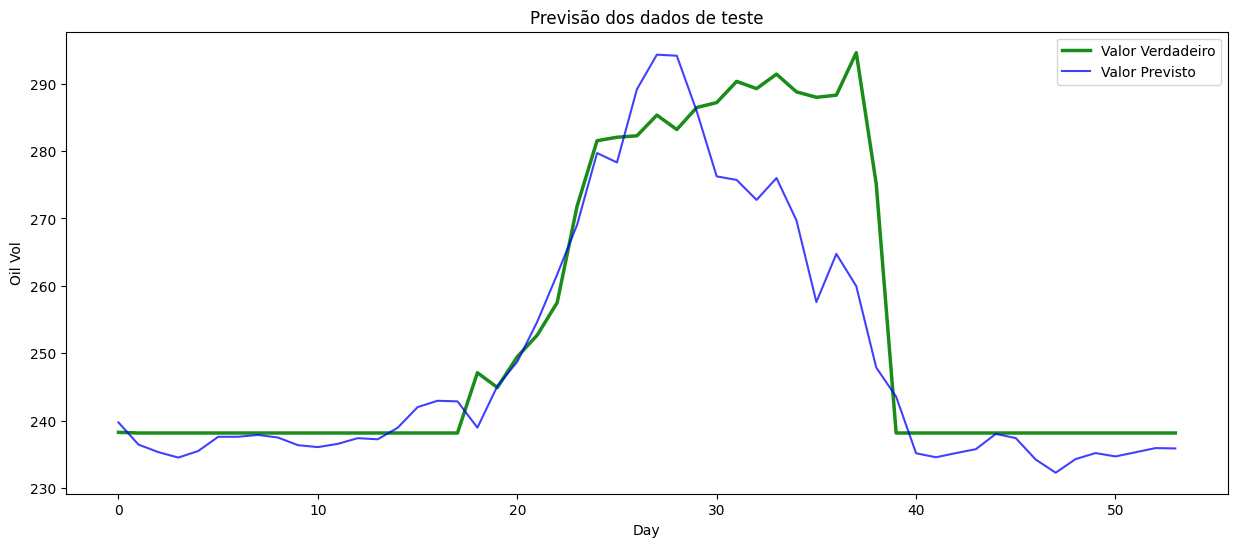

In [57]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
# plt.xlim([1000,1250])
plt.ylabel("Oil Vol")
plt.xlabel("Day")
plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5,label='Valor Verdadeiro')
plt.plot(testPredict, c = "b", alpha = 0.75,label='Valor Previsto')
plt.legend()
plt.title("Previsão dos dados de teste")
plt.show()

In [58]:
rmse = np.sqrt(mean_squared_error(y_test_true_scaled, testPredict_scaled))
print("Test(Validation) RMSE ="  ,rmse)

Test(Validation) RMSE = 0.035845384


In [59]:
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))
print("Test(Validation) RMSE ="  ,rmse)

Test(Validation) RMSE = 9.878489


In [60]:
optuna.visualization.plot_contour(study)

In [61]:
optuna.visualization.plot_optimization_history(study)

In [62]:
optuna.visualization.plot_intermediate_values(study)